# 深度卷积生成对抗网络

生成器 (Generator)("艺术家") & 判别器 (Discriminator)("艺术评论家")

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython import display

准备 MNIST 手写数据集

In [2]:
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()
train_images.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # [0, 255] -> [-1, 1]

In [0]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

创建生成器网络

In [0]:
def make_generator_model():
    model = keras.Sequential([
        keras.layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Reshape((7, 7, 256)),
        keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

tf.Tensor(
[[-0.836243   -0.369106   -0.40972394 -0.17025787 -0.69386274 -2.6798515
  -0.50801593  0.805225    0.43764713 -0.8478295  -0.01205852 -0.17711839
   0.16512172  0.35288265  1.2600393   0.90654343 -0.9352194   0.33448204
  -0.54273856 -0.25338218 -0.97457933 -1.0614158   1.0386753  -0.18037719
  -1.7074761   0.3484895  -0.46852517  0.54609096 -0.19146878 -2.0220723
   0.15249124 -0.177925   -0.5389189  -0.26192692  0.30811352 -1.036532
   0.93559706 -0.12596036  0.08275323  0.8475547   0.12433832  0.78487074
   0.19712354  1.952833    0.24985252 -0.16362563  0.572147   -0.45703992
   0.00881551 -0.7987579  -2.2220986   2.3566825  -0.01556182  1.5066895
   1.2364411  -1.3026112   0.13163595  0.07413062  0.25243554 -1.1042047
  -0.70912915 -0.8536726   2.7345796   0.59409845 -0.3746831   1.1746628
  -0.1327569  -0.6053498   0.19670613  1.1609563  -0.2285366   0.12042303
   1.9393572  -0.7381622   0.5301841   1.5633557   0.48501858  0.72609
   1.7681336   1.4572216  -0.27988073

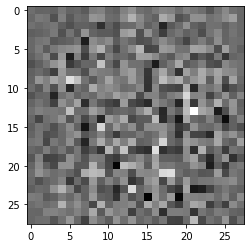

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise)
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

创建判别器网络

In [0]:
def make_discriminator_model():
    model = keras.Sequential([
        keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(1)
    ])
    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00080273]], dtype=float32)>

In [0]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# 判别器损失
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [0]:
# 生成器损失: 把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_opt = keras.optimizers.Adam(1e-4)
discriminator_opt = keras.optimizers.Adam(1e-4)

Train

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = generator_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def save_images(epoch, predictions):
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
            print(".", end="")

        display.clear_output(wait=True)
        predictions = generator(seed)
        save_images(epoch+1, predictions)
        print("\r{}".format(epoch), end=" ")

    display.clear_output(wait=True)
    predictions = generator(seed)
    save_images(epochs, predictions)

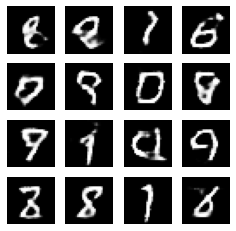

In [17]:
train(train_dataset, EPOCHS)

In [0]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
